<a href="https://colab.research.google.com/github/WaheedMomna/Assignment2/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
%matplotlib inline
from torchsummary import summary
import torch.nn as nn
import torchvision.models as models



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
device

'cpu'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/A2/CS867 Sp2022_A2_Dataset/train_and_val_set.tar'

In [ ]:
!ls train_set/images/

In [148]:
import numpy as np

anot = np.load('/content/train_set/annotations/90540_exp.npy', allow_pickle=True)


In [149]:
print(anot)
print(anot.shape)

6
()


In [5]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a dictionary to convert expressions to integers
expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

# Define a dictionary to map suffixes to variable names
suffixes_dict = {'_exp.npy': 'expression', '_aro.npy': 'arousal', '_val.npy': 'valence'}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'annotations')
        self.image_suffix = '.jpg'
        
        self.image_names = os.listdir(self.image_dir)
        self.annotation_names = [name.replace(self.image_suffix, '') for name in self.image_names]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annotation_name = self.annotation_names[idx]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        # Load the annotations
        annotation = {}
        for suffix, var_name in suffixes_dict.items():
            path = os.path.join(self.annotation_dir, annotation_name + suffix)
            if os.path.exists(path):
                annotation[var_name] = np.load(path, allow_pickle=True).item()
        
        if not annotation:
            print(f"No annotations found for {image_name}")
            return None
        
        # Check if expression label is valid
        expression_label = annotation.get('expression')
        # if expression_label is None or int(expression_label) not in expressions_dict:
        #     print(expression_label,': ',f"Unknown or missing expression label for {image_name}\n")
            
        #     return None
        
        # Get the values of the annotations
        expression = expression_label
        expression = int(expression)
        arousal = float(annotation.get('arousal'))
        valence = float(annotation.get('valence'))


        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Convert the annotations to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float)
        expression = torch.tensor(expression, dtype=torch.long)
        arousal = torch.tensor(arousal, dtype=torch.float)
        valence = torch.tensor(valence, dtype=torch.float)
        
        return image, expression, arousal, valence


# Define the transforms to apply to the images
transform = transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])

# Define the train dataset and data loader
dataset = FaceDataset('/content/train_set', transform=transform)

# Filter out examples with errors
#dataset = [d for d in dataset if d is not None]

# Calculate dataset sizes


# Calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=True, 
    num_workers=2)


In [6]:

images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
#denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Print the shape of the images and labels
print(images.shape)
print(expression.shape)
print(arousal.shape)
print(valence.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64])
torch.Size([64])


In [115]:
image_suffix = '.jpg'
expression_suffix = '_exp.npy'
print('/content/train_set/annotations/281615.jpg'.replace(image_suffix,expression_suffix))

/content/train_set/annotations/281615_exp.npy


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

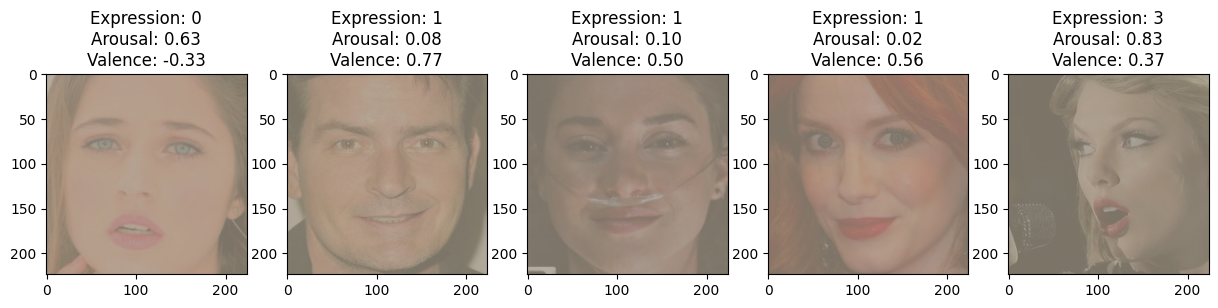

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 images and their labels
images, expression_labels, arousal_labels, valence_labels = next(iter(train_loader))
images = images[:5]
expression_labels = expression_labels[:5]

# Denormalize the images (undo the normalization done in the transform)
denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Convert expression labels from tensors to numpy arrays
expression_labels = expression_labels.numpy()

# Plot the images and their labels
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    # Transpose the image tensor to (height, width, channels) format for plotting
    img = denormalized_images[i].permute(1, 2, 0).numpy()
    ax[i].imshow(img)
    ax[i].set_title(f"Expression: {expression_labels[i]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}")
    #labels = [f"{expressions_dict_rev[expression[i]]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}" for i in range(64)]
plt.show()
#expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

In [15]:


class ResNetModified(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModified, self).__init__()
        self.num_classes = num_classes
        self.resnet = models.resnet18(pretrained=True)

        # Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        layers_to_unfreeze = ['layer4', 'avgpool']
        for name, child in self.resnet.named_children():
            if name in layers_to_unfreeze:
                for param in child.parameters():
                    param.requires_grad = True

        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 512)
        self.classification = nn.Linear(512, num_classes)
        self.arousal_regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
        self.valence_regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.fc2(x)
        classification = self.classification(x)
        arousal_regression = self.arousal_regression(x)
        valence_regression = self.valence_regression(x)
        return classification, arousal_regression, valence_regression

model = ResNetModified(num_classes=8)


In [ ]:
model

In [6]:
model = models.resnet18(pretrained=True)
model.fc.in_features

512

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms, datasets
# Define the loss functions
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    for i, (images, expression_labels, arousal_labels, valence_labels) in enumerate(train_loader):
        # Forward pass
        print(images)
        outputs, regression_outputs = model(images)
        classification_loss_value = classification_loss(outputs, expression_labels)
        regression_loss_value_arousal = regression_loss(regression_outputs[:, 0], arousal_labels)
        regression_loss_value_valence = regression_loss(regression_outputs[:, 1], valence_labels)
        loss = classification_loss_value + regression_loss_value_arousal + regression_loss_value_valence
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log loss
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        total_classification_loss = 0.0
        total_regression_loss_arousal = 0.0
        total_regression_loss_valence = 0.0
        total_correct = 0
        total_samples = 0
        for images, expression_labels, arousal_labels, valence_labels in val_loader:
            # Forward pass
            outputs, regression_outputs = model(images)
            classification_loss_value = classification_loss(outputs, expression_labels)
            print(regression_outputs)
            regression_loss_value_arousal = regression_loss(regression_outputs[:, 0], arousal_labels)
            regression_loss_value_valence = regression_loss(regression_outputs[:, 1], valence_labels)
            loss = classification_loss_value + regression_loss_value_arousal + regression_loss_value_valence
            
            # Compute statistics
            total_classification_loss += classification_loss_value.item() * images.size(0)
            total_regression_loss_arousal += regression_loss_value_arousal.item() * images.size(0)
            total_regression_loss_valence += regression_loss_value_valence.item() * images.size(0)
            
            total_samples += images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == expression_labels).sum().item()

        # Compute and print statistics
        avg_classification_loss = total_classification_loss / total_samples
        avg_regression_loss_arousal = total_regression_loss_arousal / total_samples
        avg_regression_loss_valence = total_regression_loss_valence / total_samples
        accuracy = total_correct / total_samples
        print('Epoch [{}/{}], Classification Loss: {:.4f}, Regression Loss (Arousal): {:.4f}, Regression Loss (Valence): {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, avg_classification_loss, avg_regression_loss_arousal, avg_regression_loss_valence, accuracy))
        #logging.info('Epoch [{}/{}], Classification Loss: {:.4f}, Regression Loss (Arousal): {:.4f}, Regression Loss (Valence): {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, avg_classification_loss, avg_regression_loss_arousal, avg_regression_loss_valence, accuracy))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')







In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes_exp, num_classes_av):
        super(CustomClassifier, self).__init__()
        self.fc_exp = nn.Linear(in_features, num_classes_exp)
        self.fc_av = nn.Linear(in_features, num_classes_av)
        
    def forward(self, x):
        out_exp = self.fc_exp(x)
        out_av = self.fc_av(x)
        return out_exp, out_av

class ResNet18(nn.Module):
    def __init__(self, num_classes_exp=8, num_classes_av=2):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        layers_to_unfreeze = ['layer4', 'avgpool']
        for name, child in self.resnet.named_children():
            if name in layers_to_unfreeze:
                for param in child.parameters():
                    param.requires_grad = True
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        
        # Replace the final fully connected layer with a new one with the desired number of classes
        self.resnet.fc = CustomClassifier(num_ftrs, num_classes_exp, num_classes_av)
    
    def forward(self, x):
        out = self.resnet(x)
        return out




class Trainer():
    def __init__(self, model, class_criterion, reg_criterion, optimizer, device):
        self.model = model
        self.class_criterion = class_criterion
        self.reg_criterion = reg_criterion
        self.optimizer = optimizer
        self.device = device

    
    def accuracy_av(self, output_av, target_arousal, target_valence):
        pred_arousal, pred_valence = output_av[:, 0], output_av[:, 1]
        diff_arousal = torch.abs(pred_arousal - target_arousal)
        diff_valence = torch.abs(pred_valence - target_valence)
        correct_arousal = (diff_arousal <= 0.5).sum().item()
        correct_valence = (diff_valence <= 0.5).sum().item()
        correct_av = (diff_arousal <= 0.5) & (diff_valence <= 0.5)
        return (correct_av.sum().item(), correct_arousal, correct_valence)
    
    def train(self, train_loader):
        self.model.train()
        train_loss = 0
        correct_exp = 0
        correct_av = 0
        
        for batch_idx, (data, target_exp, target_arousal, target_valence) in enumerate(tqdm(train_loader)):
            data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
            self.optimizer.zero_grad()
            output_exp, output_av = self.model(data)
            loss_exp = self.class_criterion(output_exp, target_exp)
            loss_av = self.reg_criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
            loss = loss_exp + loss_av
            train_loss += loss.item()
            pred_exp = output_exp.argmax(dim=1, keepdim=True)
            correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
            correct_av += self.accuracy_av(output_av, target_arousal, target_valence)[0]
            
            loss.backward()
            self.optimizer.step()
        train_loss /= len(train_loader.dataset)
        accuracy_exp = 100. * correct_exp / len(train_loader.dataset)
        accuracy_av = 100. * correct_av / len(train_loader.dataset)
        return train_loss, accuracy_exp, accuracy_av
    
    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0
        correct_exp = 0
        correct_av = 0
        with torch.no_grad():
            for data, target_exp, target_arousal, target_valence in val_loader:
                data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
                output_exp, output_av = self.model(data)
                loss_exp = self.criterion(output_exp, target_exp)
                loss_av = self.criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
                loss = loss_exp + loss_av
                val_loss += loss.item()
                pred_exp = output_exp.argmax(dim=1, keepdim=True)
                correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
                correct_av += self.accuracy_av(output_av, target_arousal, target_valence)[0]
        val_loss /= len(val_loader.dataset)
        accuracy_exp = 100. * correct_exp / len(val_loader.dataset)
        accuracy_av = 100. * correct_av / len(val_loader.dataset)
        return val_loss, accuracy_exp, accuracy_av










In [19]:
# Define hyperparameters and training settings
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 32
num_classes = 8

# Create ResNet18 model and move it to device
model = ResNet18().to(device)


# Define loss function and optimizer
class_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Create Trainer object
trainer = Trainer(model=model, class_criterion=class_criterion,reg_criterion=reg_criterion, optimizer=optimizer, device=device)

# Train the model
for epoch in range(num_epochs):
    print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, learning_rate))
    train_loss, train_accuracy = trainer.train(train_loader)
    print('Train loss: %.4f'%(train_loss))
    print('Train_accuracy %.2f' % (train_accuracy))
    print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, learning_rate))
    val_loss, val_accuracy = trainer.validate(val_loader)
    print('val_loss: %.4f'%(val_loss))
    print('val_accuracy %.2f' % (val_accuracy))
    
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}% - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')

# Define the file path to save the trained model
model_path = 'resnet18_trained.pth'

# Save the trained model state dictionary to the specified file path
torch.save(model.state_dict(), model_path)



Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 9/3596 [01:33<10:24:13, 10.44s/it]


KeyboardInterrupt: ignored

In [14]:
# Select a loss function
class_loss = torch.nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10

model= ResNet18().to(device);


In [15]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/drive/MyDrive/A2/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/drive/MyDrive/A2/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

In [21]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = trainer.train(train_loader)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = trainer.validate(val_loader)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  #writer.flush()


Epoch 0: Train 
Learning Rate: 0.001000


  6%|▌         | 223/3596 [39:46<10:01:35, 10.70s/it]


KeyboardInterrupt: ignored

In [41]:
def run_1_epoch(model, class_loss,reg_loss, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds_exp = 0
  total_correct_preds_ar = 0
  total_correct_preds_val = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(train_loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  
  for batch_idx, (data, target_exp, target_arousal, target_valence) in enumerate(tqdm(train_loader)):
    data, target_exp, target_arousal, target_valence = data.to(device), target_exp.to(device), target_arousal.to(device), target_valence.to(device)
    # Transfer image_batch to GPU if available
    data = data.to(device)
    target_exp = target_exp.to(device)
    target_arousal = target_arousal.to(device)
    target_valence = target_valence.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output_exp, output_av = model(data)
    out_arousal, out_valence = output_av[:, 0], output_av[:, 1]
    output_exp = torch.tensor(output_exp)
    out_arousal = torch.tensor(out_arousal)
    out_valence = torch.tensor(out_valence)
    # Acquire predicted class indices
    #print(torch.max(out_arousal.data, 1))
    # _, exp_predicted = torch.max(output_exp.data, 1) # the dimension 1 corresponds to max along the rows 
    # print(out_arousal.data)
    # _, arousal_predicted = torch.max(out_arousal.data, 1) # the dimension 1 corresponds to max along the rows
    # _, valence_predicted = torch.max(out_valence.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output_exp.squeeze_(-1)
    out_arousal.squeeze_(-1)
    out_valence.squeeze_(-1)

    # Compute the loss for the minibatch
    exp_loss = class_loss(output_exp, target_exp)
    ar_loss = reg_loss(out_arousal, target_arousal)
    val_loss = reg_loss(out_valence, target_valence)
    
    loss = exp_loss + ar_loss + val_loss
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds_exp += (output_exp == target_exp).sum().item()
    total_correct_preds_ar += (out_arousal == target_arousal).sum().item()
    total_correct_preds_val += (out_valence == target_valence).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy_exp = 100 * total_correct_preds_exp / total_samples_in_loader
  accuracy_ar = 100 * total_correct_preds_ar / total_samples_in_loader
  accuracy_val = 100 * total_correct_preds_val / total_samples_in_loader

  return loss, accuracy_exp, accuracy_ar,accuracy_val

In [33]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_exp = []
train_accuracy_ar = []
train_accuracy_val = []
val_accuracy_exp = []
val_accuracy_ar = []
val_accuracy_val = []


train_loss_list = []
val_loss_list = []


val_accuracy_max_exp = -1
val_accuracy_min_ar = 2
val_accuracy_min_val = 2

checkpoint_path = '/content/drive/MyDrive/A2/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/drive/MyDrive/A2/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

# Select a loss function
class_loss = torch.nn.CrossEntropyLoss()
reg_loss = nn.MSELoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [27]:
class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes_exp, num_classes_av):
        super(CustomClassifier, self).__init__()
        self.fc_exp = nn.Linear(in_features, num_classes_exp)
        self.fc_av = nn.Linear(in_features, num_classes_av)
        
    def forward(self, x):
        out_exp = self.fc_exp(x)
        out_av = self.fc_av(x)
        return out_exp, out_av


resnet = models.resnet18(pretrained=True)
        
# Freeze layers
for param in resnet.parameters():
  param.requires_grad = False

# Unfreeze last few layers
layers_to_unfreeze = ['layer4', 'avgpool']
for name, child in resnet.named_children():
  if name in layers_to_unfreeze:
    for param in child.parameters():
      param.requires_grad = True        
# Get the number of input features to the final fully connected layer
num_ftrs = resnet.fc.in_features
        
# Replace the final fully connected layer with a new one with the desired number of classes
resnet.fc = CustomClassifier(num_ftrs, 8, 2)
    

In [42]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  loss, accuracy_exp, accuracy_ar,accuracy_val  = run_1_epoch(resnet, class_loss,reg_loss, train_loader, optimizer, train = True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_accuracy_exp.append(accuracy_exp)
  train_accuracy_ar.append(accuracy_ar)
  train_accuracy_val.append(accuracy_val)
  train_loss_list.append(loss)
  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy_exp, val_accuracy_ar,val_accuracy_val  = run_1_epoch(model, class_loss,reg_loss, train_loader, optimizer = None, train = False)
  
  # Lists for val loss and accuracy for plotting
  val_accuracy_exp.append(val_accuracy_exp)
  val_accuracy_ar.append(val_accuracy_ar)
  val_accuracy_val.append(val_accuracy_val)
  val_loss_list.append(val_loss)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy_exp >= val_accuracy_max_exp and val_accuracy_min_ar >= val_accuracy_ar and val_accuracy_min_val >= val_accuracy_val :
    val_accuracy_max_exp = val_accuracy_exp
    val_accuracy_min_ar = val_accuracy_ar
    val_accuracy_min_val = val_accuracy_val
    print('New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.\n\n')

    checkpoint = {
      'model': resnet.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp,
      'train_accuracy_val': train_accuracy_val,
      'train_accuracy_ar': train_accuracy_val,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp,
      'val_accuracy_val': val_accuracy_val,
      'val_accuracy_ar': val_accuracy_ar,
      'val_accuracy_exp': val_accuracy_exp,
      'val_rmse_val_min': val_accuracy_min_val,
      'val_rmse_aro_min': val_accuracy_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
    torch.save(checkpoint, best_val_checkpoint_path)
  else:
      print("val accuracy and RMSEs did not improve.\n\n")
      checkpoint = {
      'model': resnet.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp,
      'train_accuracy_val': train_accuracy_val,
      'train_accuracy_ar': train_accuracy_val,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp,
      'val_accuracy_val': val_accuracy_val,
      'val_accuracy_ar': val_accuracy_ar,
      'val_accuracy_exp': val_accuracy_exp,
      'val_rmse_val_min': val_accuracy_min_val,
      'val_rmse_aro_min': val_accuracy_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
      torch.save(checkpoint, checkpoint_path)
  #writer.flush()


Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/3596 [00:13<?, ?it/s]


RuntimeError: ignored